In [28]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1500)
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import linalg
from collections import defaultdict, namedtuple

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Politcal blogs dataset [35 points]

We will study a political blogs dataset first compiled for the paper Lada A. Adamic and Natalie Glance,
“The political blogosphere and the 2004 US Election”, in Proceedings of the WWW-2005 Workshop on the
Weblogging Ecosystem (2005). The dataset nodes.txt contains a graph with n = 1490 vertices (“nodes”)
corresponding to political blogs. Each vertex has a 0-1 label (in the 3rd column) corresponding to the
political orientation of that blog. We will consider this as the true label and try to reconstruct the true label
from the graph using the spectral clustering on the graph. The dataset edges.txt contains edges between the
vertices. You may remove isolated nodes (nodes that are not connected any other nodes).

In [2]:
class Distances:
    '''
    This class is responsible for all distance calculations. Supported distance metrics are from the set
    {eucl, eucl_squared, manhattan, minkowski}. Each method underneath calls the minkowski methods since
    each metric is a variant of the minkowski distance with respect to a different power, p.
    '''
    def __init__(self, distance: str) -> None:
        '''
        inputs
        ------
        distance (str) -> The distance metric desired from the set {eucl, eucl_squared, manhattan, minkowski}
        '''
        assert distance in ('eucl', 'eucl_squared', 'manhattan', 'minkowski'), 'Distance "{}" not understood. Please choose from ("eucl" | "eucl_squared" | "manhattan" | "minkowski")'.format(distance)
        self.distance = distance
        
    def _calculate_distance(self, p1: np.array, p2: np.array, p=None) -> np.array:
        
        
        if self.distance == 'eucl':
            return self._euclidean(p1, p2)
        
        elif self.distance == 'eucl_squared':
            return self._euclidean(p1, p2)**2
        
        elif self.distance == 'manhattan':
            return self._manhattan(p1, p2)
        
        elif self.distance == 'minkowski' or (p>2 or p<1):
            return self._minkowski(p1, p2, p)
        
    def _euclidean(self, p1: np.array, p2:np.array) -> np.array:
        '''
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        eucl: array -> euclidean distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for euclidean distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 euclidean distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        eucl = self._minkowski(p1, p2, 2)
        
        return eucl
    
    def _manhattan(self, p1: np.array, p2: np.array) -> np.array:
        '''
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        manhan: array -> manhattan distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for euclidean distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 euclidean distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        manhan = self._minkowski(p1, p2, 1)
        return manhan
    
    def _minkowski(self, p1: np.array, p2: np.array, p: int) -> np.array:
        '''
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        mink: array -> manhattan distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for euclidean distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 euclidean distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        mink = np.sum(np.abs(p1-p2)**p, axis=1)**(1/p)
        return mink

    
  


    
class RandomInit:
    def __init__(self, method: str)-> None:
        '''
        This class is responsible for randomly initializing centroids for either kmeans or kmedoids algorithms
        
        inputs
        ------
        method: (str) -> type of initialization need (kmedoids | kmeans)
        '''
        assert method in ('kmedoids', 'kmeans'), 'RandomInit method "{}" not understood. Please choose (kmedoids | kmeans)'.format(method)
        self.method = method
        
        
    def _initialize(self, x: np.array, k: int):
        if self.method == 'kmedoids' and x is None:
            raise Exception('Invalid Parameter - method chosen "kmedoids" but no data given')
        elif self.method == 'kmedoids' and k is None:
            raise Exception('Invalid Parameter - method chosen "kmedoids" but no k given')
        
        if self.method == 'kmeans' and k is None:
            raise Exception('Invalid Parameter - method chosen "kmeans" but no k given')
        elif self.method == 'kmeans' and x is None:
            raise Exception('Invalid Parameter - method chosen "kmeans" but no data given')
            
        if self.method == 'kmedoids':
            return self._kmedoids_init(x=x, k=k)
        
        elif self.method == 'kmeans':
            return self._kmeans_init(k=k, x=x)

    def _kmedoids_init(self, x: np.array, k: int)->list:
        '''
        initializes k kmedoid cluster centers by randomly selecting k data points from
        the input data
        
        inputs
        ------
        x: np.array -> The training data of shape (m,n)
        k: int -> The number of desired cluster centers
        
        outputs
        -------
        clusters: np.array -> k randomly selected data points to be the cluster centroids
        
        '''
        
        #holds the randomly selected data point indices
        cluster_idxs = []
        
        for i in range(k):
            #random select a datapoint index
            rand_cluster = np.random.randint(0, len(x))
            #if this point has been previously selected, select another one
            while rand_cluster in cluster_idxs:
                rand_cluster = np.random.randint(0, len(x))
            #add new data point index
            cluster_idxs.append(rand_cluster)
        #return data points located at the randomly chosen indices
        return x[cluster_idxs]
    
    def _kmeans_init(self, x: np.array, k: int) -> np.array:
        '''
        initializes k random cluster centroids by randomly selecting k values for 
        each dimension's domain in x
        
        inputs
        ------
        x: np.array -> The training data of shape (m,n)
        k: int -> the number of desired cluster centers
        
        outputs
        -------
        rand_centroids: np.array -> k randomly initialized centroids of shape (k,n)
        '''
        #get the min value for each column in x
        min_domain = np.min(x, axis=0)
        #get the max value for each column in x
        max_domain = np.max(x, axis=0)
        #get the shape of x
        m,n = x.shape
        
        #randomly generated k cluster centroids between the low and hi domains for each column
        rand_centroids = np.random.uniform(low=min_domain, high=max_domain, size=(k,n))
        
        return rand_centroids
    
    
class uniformInit:
    '''
    This class is responsible for creatting a uniform intialization of cluster centers for Kmedoids.
    It sorts the input x and then selects k equally spaced points from the sorted array. It returns
    the equidistant clusters as centers for the Kmedoids algorithm
    '''
    def _initialize(self, x, k):
        '''
        inputs
        ------
        x: np.array -> data points to be clustered
        k: int -> number of clusters
        
        outputs
        -------
        cluster_centers: np.array -> k equally distant points
        '''
        #sort the points
        x = np.sort(x)
        
        #get total points
        m = x.shape[0]
        
        #list to store the index positions
        idxs = []
        #get an index for each cluster
        for i in range(1, k+1):
            
            frac = i / k
            idx = int(frac * m) - 1
            idxs.append(idx)
            
        #return cluster centers
        return x[idxs]
                    

                
                
                
class KMeans:

    def __init__(self, k: int, distance_metric: str, p=None, iterations=1000, initializer='random', verbose=True) -> None:
        '''
        This class is the main driver for a KMeans implementation. The initializer calls the 
        RandomInit Class and passes the proper arguments for Kmeans initialization. The distance
        metric is called from the Distances class. The distance metric is pass forward as a parameter
        to the Distance class
        '''

        self.k = k
        self.distance = Distances(distance=distance_metric)
        if initializer=='random':
            self.initializer = RandomInit(method='kmeans')
        elif initializer=='bad':
            self.initializer = badInit()
        elif initializer == 'uniform':
            self.initializer = uniformInit()
        self.p = p
        self.iterations = iterations
        self.verbose = verbose
        self.converged = False
        
    def fit(self, x):
        m,n = x.shape
        
        #initialize dict to accumulate cost for each centroid
        self.centroid_costs = {c:0 for c in range(self.k)}
        
        #initialize empty array to hold cluster assignments
        self.cluster_assignments = np.zeros((m,1))
        
        #randomly initialize k clusters
        self.cluster_centers = self.initializer._initialize(x=x, k=self.k)
        
        #begin cluster assignment
        for i in range(self.iterations):
            if self.verbose:
                print('Iteration', i)
                
            #check if we have converged
            if self.converged:
                if self.verbose:
                    print('Converged!')
                return
            
            #assign each point to a cluster
            self._assign(x)
            
            #keep a copy of the current centroids
            old_centroids = self.cluster_centers.copy()

            #update cluster centroids
            self._update_centroids(x)
            
            #check if old_centroids are equal to new centroids - no change means we have converged
            if (old_centroids == self.cluster_centers).all():
                self.converged = True

            #reset the costs in preparation for the next cycle
            self.centroid_costs = {c:0 for c in range(self.k)}
            
            
            
    def _assign(self, x):
        #classify each data point by calculating distances
        for i in range(x.shape[0]):
            
            #isolate a single data point
            current_data_point = x[i,:].reshape(1,-1)
                
            #calculate the distance of the current datapoint to each centroid
            distance = self.distance._calculate_distance(current_data_point, self.cluster_centers, self.p)

            #the cluster assignment for current point is the argmin of distance
            assignment = np.argmin(distance)

            #get the cost associated with this assignment - this is located at the position of the argmin (assignment)
            cost = distance[assignment]
            
            #save assignment
            self.cluster_assignments[i] = assignment
            
            #update the cost for the current centroid
            self.centroid_costs[assignment] += cost
            
    def _update_centroids(self, x):

            #for each cluster
            for pos, c in enumerate(range(self.k)):

                #get all data points that exist in cluster c
                cx = x[(self.cluster_assignments == c).ravel()]
                
                #if a cluster has been assigned points
                if cx.any().any():
                    #calculate the positional mean
                    cluster_mean = np.mean(cx, axis=0)

                    #update the cluster centroid with the mean
                    self.cluster_centers[pos] = cluster_mean
                    


## 1. Assume the number of clusters in the graph is k. Explain the meaning of k here intuitively 

### **Answer** 

* k (with respect to eigenvectors/eigenvalues) - The laplacian of the adjacency matrix is generated and from this, eigenvalues and eigenvectors are calculated. A laplacian of k columns will have k eigenvectors and eigenvalues. If a laplacian has k eigenvalues such that $\lambda_1 = \lambda_2 = ... = \lambda_k = 0$, it is said that the network has **k - connected components**. Eigenvectors with $\lambda$ > 0 express the level of "connectivity" of the connected nodes. The larger the eigenvalue, the stronger the connectivity. However, for better cluster separation, we want an eigenvalue that is as low as possible (weaker connectivity for easier discrimination between clusters).

* k (with respect to clusters) - If the graph is grouped into k clusters, it is interpreted (hopefully) that each cluster would be indicative of nodes that have high connection strength, thus share the same political orientation, or possibly share the same topic with regards to the blog itself

## 2. Use spectral clustering to find the k = 2, k = 3, and k = 4 clusters in the network of political blogs (each node is a blog, and their edges are defined in the file edges.txt). Then report the majority labels in each cluster, when k = 2, 3, 4, respectively. For example, if there are k = 2 clusters, and their labels are {0, 1, 1, 1} and {0, 0, 1} then the majority label for the first cluster is 1 and for the second cluster is 0. It is required you implementing the algorithms yourself rather than calling from a package.

In [3]:
#load data
edges = pd.read_csv('edges.txt', sep='\t', header=None, names=['from','to'])
nodes = pd.read_csv('nodes.txt', sep='\t', header=None, names=['node', 'blog', 'class', 'source'])

print('Total nodes in file: ',len(nodes))

Total nodes in file:  1490


In [4]:
#remove nodes that are isolated (has no edges)

#get all nodes in nodes list
nodes_in_nodes_list = nodes.node.values

#create a set of all unique nodes in the 'from' list
nodes_in_edges_list_from = edges['from'].unique()
#create a set of all unique nodes in the 'to' list
nodes_in_edges_list_to = edges['to'].unique()
#take the union of the two sets
nodes_in_edges = np.union1d(nodes_in_edges_list_from, nodes_in_edges_list_to)

#isolated nodes are those in nodes list that don't appear in the edge lists
#take the intersection of the two which will remove the isolated nodes
nodes_in_clusters = np.intersect1d(nodes_in_nodes_list, nodes_in_edges)

#remove isolated nodes from the nodes list
nodes = nodes[nodes.node.isin(nodes_in_clusters)].reset_index().drop('index',axis=1)

print('Total connected nodes: ', len(nodes))

Total connected nodes:  1224


In [5]:
def create_A_matrix(nodes: np.array, edges: np.array) -> np.array:
    
    #get the total number of nodes (largest node in nodes list)
    m = max(nodes)+1
    
    #create an empty m x m matrix
    A = np.zeros((m,m))
    
    #fill out adjacency matrix with edges
    for nodeA, nodeB in edges:
        A[nodeA, nodeB] = 1
        A[nodeB, nodeA] = 1

    
        
    
    return A[nodes[:,None], nodes]

In [6]:
def create_D_matrix(A: np.array) -> np.array:
    
    #total connections for a node is the sum of adjacencies from A matrix
    sums = np.sum(A, axis=1)
    
    #D is then just a diagonal matrix of the sums
    D = np.diag(sums)
    
    return D

In [7]:
def create_L_matrix(nodes: np.array, edges: np.array) -> np.array:
    
    A = create_A_matrix(nodes, edges)
    
    D = create_D_matrix(A)
    
    L = D - A
    
    return L

In [8]:
def eigens(L: np.array, k: int) -> np.array:
    
    #eigenvalues and eigenvectors of L matrix
    eigvals, eigenvects = linalg.eig(L)
    
    #eigenvals and eigenvecs are guaranteed to be sorted
    #sort the eigenvals
    sorted_indices = np.argsort(eigvals)
    sorted_ = eigvals[sorted_indices]
    
    #sort eigenvector columns by the sorted eigenvalues
    #cast from type(complex) to type(real)
    eigenvects = np.real(eigenvects[:, sorted_indices])
    
    #eigenvalues cast from type(complex) to type(real)
    eigvals = np.real(sorted_)
    
    #return vals, vects up to k columns
    return eigvals, eigenvects[:, :k]

In [9]:
def draw_graph(G):
    plt.figure(figsize=(20,10))
    pos = nx.spring_layout(G, iterations = 25)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, node_size=2)

## Visualize the Network 

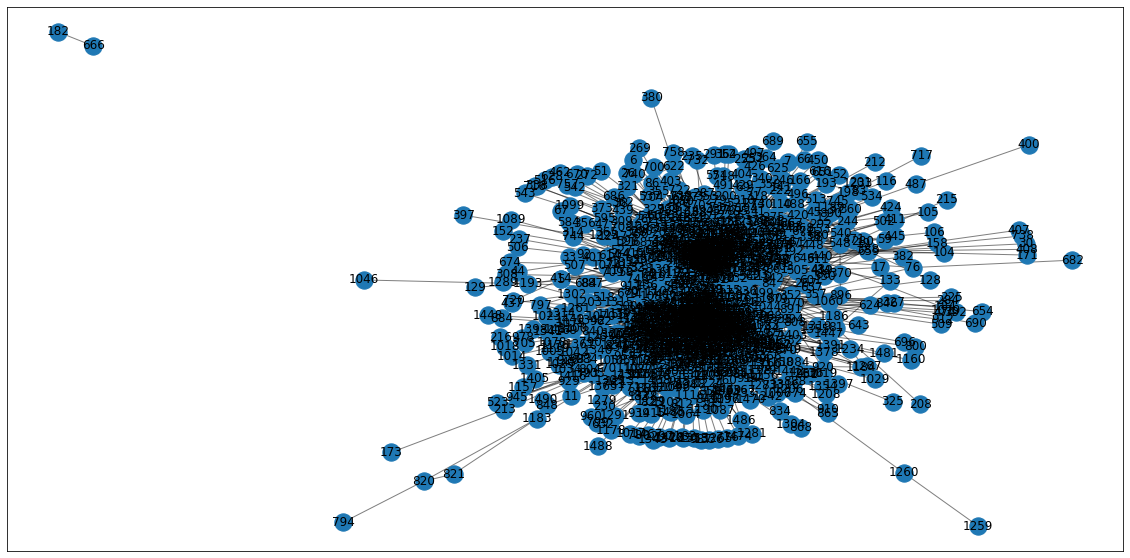

In [10]:
G =nx.read_edgelist("edges.txt", nodetype=int,delimiter='\t')
draw_graph(G)

### We will be using the networkx library to validate our implementation of the Laplacian Matrix. It is only used to validate the results of our self implemented code

In [11]:
#networkx adjacency matrix
W = nx.adjacency_matrix(G,nodelist=sorted(G.nodes())).toarray()

#my adjacency matrix
A = create_A_matrix(nodes.node.values, edges.loc[:, ['from', 'to']].values)


## are they equal?
(A == W).all().all()

True

### Let's visualize the Adjacency Matrix 

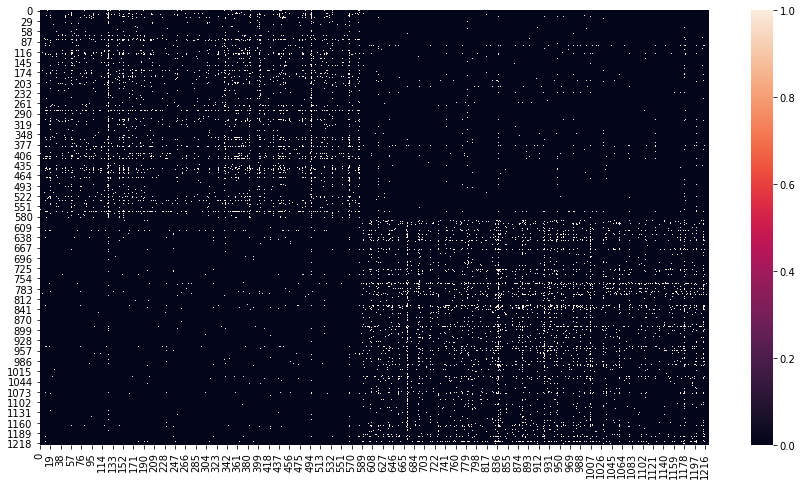

In [12]:
plt.figure(figsize=(15,8))
sns.heatmap(A)
plt.show()

### We can see clearly from the adjacency matrix that there are two clear distinct cluster blocks. Let's continue on with creating the Laplacian. Again, we will be using networkx only to verify our implementation of the Laplacian

In [13]:
#networkx laplacian
Lx = nx.laplacian_matrix(G,nodelist=sorted(G.nodes())).toarray()

#my Laplacian
L = create_L_matrix(nodes.node.values, edges.loc[:, ['from', 'to']].values)

#are they equal?
(L == Lx).all().all()

True

### Visualizing the Laplacian should present a sparse, diagonal, and symmetric matrix 

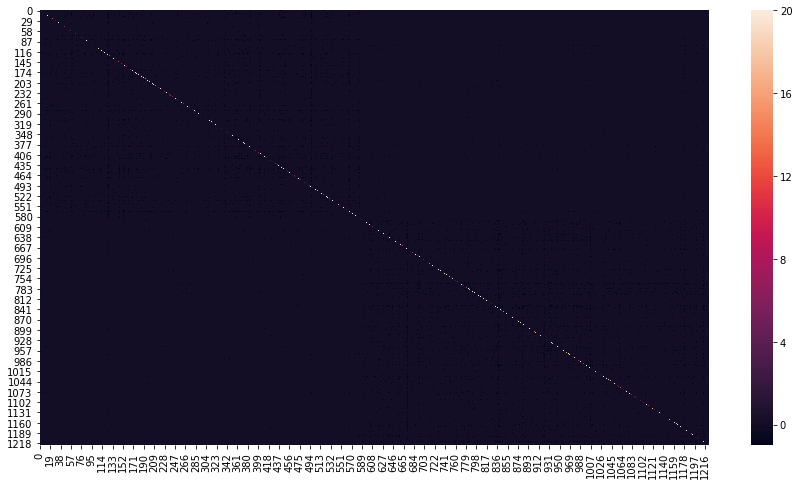

In [14]:
plt.figure(figsize=(15,8))
sns.heatmap(L, vmin=-1.0, vmax=20)
plt.show()

### As we can see above, the Laplacian is symmetric and sparse. According to spectral theory, a symmetric matrix will have only real eigenvalues. Not only this, but because we can see 2 distinct cluster blocks in the Adjacency matrix, we should see two of the eigenvalues be equal to 0. In fact, if the graph G has k different eigenvectors with eigenvalues of 0, then G has k connected components. Let's perform eigen decomposition and analyze the eigenvalues

In [15]:
#eigvals, eigvects for my Laplacian
vals, vecs = eigens(L, k=2)

In [16]:
print('Eigenval 1: ', vals[0])
print('Eigenval 2: ', vals[1])

Eigenval 1:  4.380241386347686e-15
Eigenval 2:  6.864591294635427e-14


### We can clearly see that the first two eigenvalues are indeed 0. They have precision in orders of e-15 and e-14 which is essentially 0. We can further convince ourselves of the two distinct clusters by plotting the first eigenvectors corresponding to the first two eigenvalues. In the resulting plot, we should see two distcint and separated clusters 

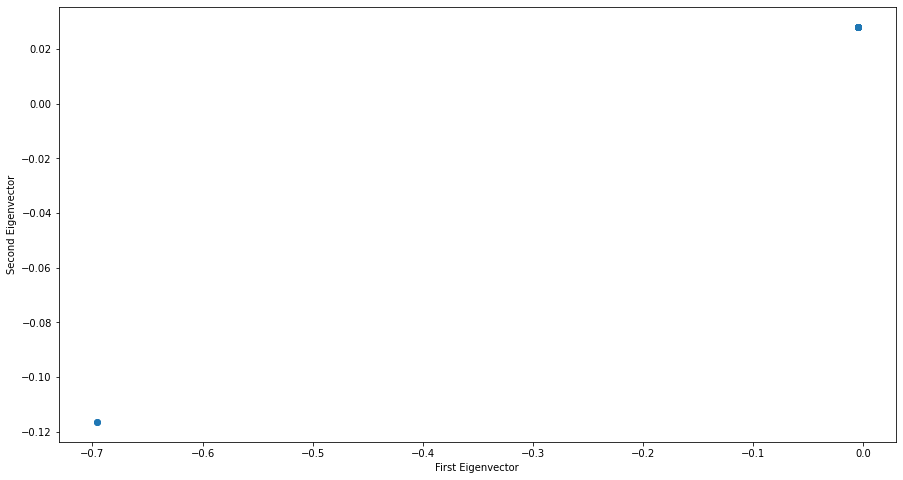

In [17]:
plt.figure(figsize=(15,8))
plt.scatter(vecs[:, 0], vecs[:, 1])
plt.xlabel('First Eigenvector')
plt.ylabel('Second Eigenvector')
plt.show()

### Perform spectral clustering for k=2,3,4 

In [18]:
def cluster_major_label(cluster_assignments):
    #group cluster assignments with their true labels
    assignment_zip_class = zip(cluster_assignments.ravel().astype(int), nodes['class'])
    
    labels_in_clusters = defaultdict(dict)
    
    #for each cluster get the total count of labels 0 & 1 present in the cluster
    for row in assignment_zip_class:

        labels_in_clusters[ row[0] ][ row[1] ] = labels_in_clusters[ row[0] ].get(row[1], 0) + 1
 
    #get the major label in each cluster  
    max_per_cluster = (max(labels_in_clusters[x], key=lambda key: labels_in_clusters[x][key])  for x in sorted(labels_in_clusters.keys()))

    #create namedtuple to hold max occuring label in each cluster
    clus_labels = ['cluster_{}'.format(x+1) for x in sorted(labels_in_clusters.keys())] 
    clusters = namedtuple('clusterMajorLabel', clus_labels)
    
    #return namedtuple
    return clusters(*max_per_cluster)




def spectral_clustering(L, k, distance_metric, initializer, verbose=False):
    #calculate eigs, add 2 to the value of k-clusters
    #because the first two eigenvalues are 0 and we want
    #the vecotrs w.r.t to the nonzero eigenvalues
    vals, vecs = eigens(L, k=k)
    #remove the first 2 eigenvectors
    vecs = vecs[:, :k]
    
    #my kmeans implementation
    cluster_model = KMeans(k=k, distance_metric=distance_metric, initializer=initializer, verbose=verbose)
    
    cluster_model.fit(vecs)
    
    return cluster_model.cluster_assignments

In [19]:
#run spectral clustering for k = 2,3,4
k_equals_2_3_4 = [spectral_clustering(L=L, k=k, distance_metric='eucl', initializer='uniform', verbose=False) for k in range(2,5)]

In [20]:
#get the major labels for each cluster for each instance of spectral clustering
results = [cluster_major_label(assignments) for assignments in k_equals_2_3_4]

In [21]:
for pos, res in enumerate(results):
    print('k={} --->  '.format(pos+2), res)

k=2 --->   clusterMajorLabel(cluster_1=1, cluster_2=0)
k=3 --->   clusterMajorLabel(cluster_1=1, cluster_2=1, cluster_3=0)
k=4 --->   clusterMajorLabel(cluster_1=0, cluster_2=1, cluster_4=1)


### **Results** 
### As we can see above, when k=2, both cluster 1 had a major label of 1 and cluster 2 had a major label of 0. When k=3, cluster 1 and 2 had a major label of 1 and cluster 3 had a major label of 0. When k=4, cluster 1 had a major label of 0, cluster 2 and 4 had a major label of 1, and cluster 3 didn't get any nodes. 


## Now compare the majority label with the individual labels in each cluster, and report the mismatch rate for each cluster, when k = 2, 3, 4. For instance, in the example above, the mismatch rate for the first cluster is 1/4 (only the first node differs from the majority) and the the second cluster is 1/3.

In [22]:
def cluster_mismatch(cluster_assignments):
    
    #group cluster assignments with their true labels
    assignment_zip_class = zip(cluster_assignments.ravel().astype(int), nodes['class'])
    
    labels_in_clusters = defaultdict(dict)
    
    #for each cluster get the total count of labels 0 & 1 present in the cluster
    for row in assignment_zip_class:

        labels_in_clusters[ row[0] ][ row[1] ] = labels_in_clusters[ row[0] ].get(row[1], 0) + 1
        
    #calculate mismatch rate
    mismatch_per_cluster = [min(labels_in_clusters[x].get(0,0), labels_in_clusters[x].get(1,0)) / (labels_in_clusters[x].get(0,0) + labels_in_clusters[x].get(1,0)) for x in sorted(labels_in_clusters.keys())]
    
    return mismatch_per_cluster
    

In [23]:
def mismatch_rate(list_of_cluster_assignments_per_k, purge=True):
    rates = []
    for k in list_of_cluster_assignments_per_k:
        r = np.array(cluster_mismatch(k))
        if purge:
            r = r[r>0]
        rates.append(np.mean(r))
        
    return rates

In [24]:
mmr = mismatch_rate(k_equals_2_3_4)

print('''
k=2 mismatch rate: {}
k=3 mismatch rate: {}
k=4 mismatch rate: {}
'''.format(mmr[0],mmr[1],mmr[2]))


k=2 mismatch rate: 0.4795417348608838
k=3 mismatch rate: 0.48111658456486045
k=4 mismatch rate: 0.40701177759517937



### **Results** 
#### Above we can see the average mismatch rate for k=2,3,4 is 48%, 48% and 41% respectively 

## Now tune your k and find the number of clusters to achieve a reasonably small mismatch rate. Please explain how you tune k and what is the achieved mismatch rate. 

In [25]:
#run spectral clustering for k = 2, ..., 200
k_equals_2_to_200 = [spectral_clustering(L=L, k=k, distance_metric='eucl', initializer='uniform', verbose=False) for k in range(2,201)]

### In analyzing the mismatch rate, there's two things we can take into account. We know there will be several clusters that will only have one or two points in them with no mismatch at all. These stringers can tend to bring down the average mismatch rate if there is a lot of them. But that doesn't adequately describe the state of things. So we will calculate 2 different mismatch rates. One that accounts for the mismatch rates of all nodes, and then mismatch rates that accounts only for nodes that actually have mismatches. We will do the latter by ignoring the nodes that have a mismatch rate of 0.

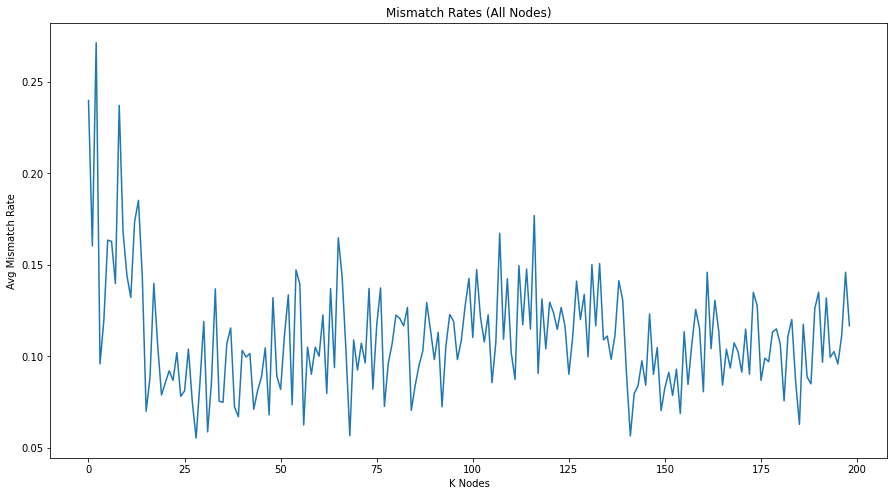

In [26]:
mmr_all = mismatch_rate(k_equals_2_to_200, purge=False)
plt.figure(figsize=(15,8))
plt.plot(mmr_all)
plt.xlabel('K Nodes')
plt.ylabel('Avg Mismatch Rate')
plt.title('Mismatch Rates (All Nodes)')
plt.show()

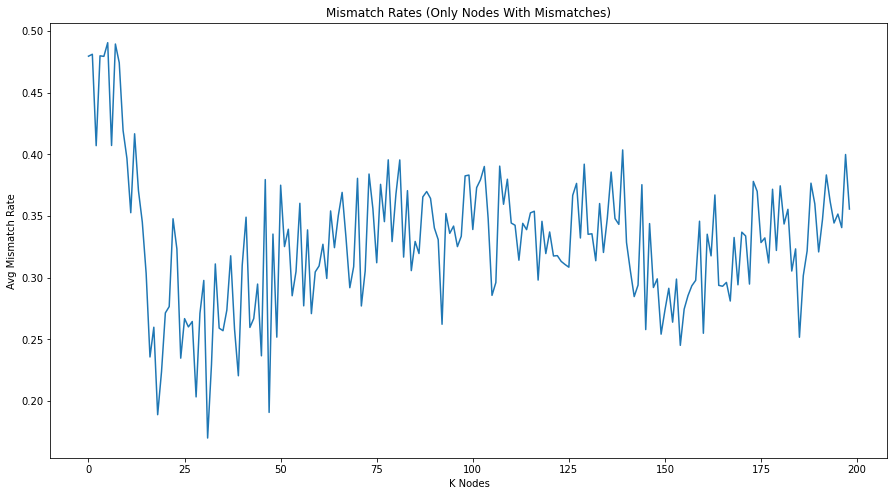

In [27]:
mmr_all = mismatch_rate(k_equals_2_to_200, purge=True)
plt.figure(figsize=(15,8))
plt.plot(mmr_all)
plt.xlabel('K Nodes')
plt.ylabel('Avg Mismatch Rate')
plt.title('Mismatch Rates (Only Nodes With Mismatches)')
plt.show()

## **Results**
### The model was tuned by simply iterating through various values of k. Also, it was seen that when a uniform initialization was utilized, the overall mismatch rates were lower than random initialization. We can also see that by accounting only nodes with mismatch rates in the averages, we get a little better picture of the magnitude of mismatches rates witnessed for each value of k where mismatches existed. When accounting for all nodes in the averages, the mismatch rate is drastically lower. This leads me to believe that with uniform initializaiton, there were several clusters of single values only which would produce 0 mismatch rate and bring down the overall mismatch averages

## Please explain the finding and what can you learn from this data analysis (e.g., node within same community tend to share the same political view, or now? Did you find blogs that share the same political view more tightly connected than otherwise?)

## **Answer**
### To be completely honest, any analysis of this graph without further information isn't quite possible. A key piece of information is missing....How are these blogs connected? Sure we have edges.txt that physically says this node is connected to that one, but there's nothing explaining what the connection link is. Are two blogs connected because one cites the other? Is it only a one way citation where one cites the other but not vice versa? Are they connected because there is actually a hyperlink from one blog to the other? Without this information, true analysis of this graph would fall short. However, one could infer a few things from this type of analysis. Since there is a relatively high mismatch rate for almost any value of k, the connections between blogs could be the actual topics the blogs are writing about. Blog A with political affiliation "a" could be writing their blog with their views on gerrymandering. Blog B with affiliation "b" could also be writing their blog with their views on gerrymandering. Even though they're opposite views with a different take on the topic, the relationship between the two could be the topic itself.